In [2]:
%pip install pandas numpy networkx matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import random
import json

# Preprocessing dei dati

In [2]:
df_posts = pd.read_csv("../../../data/post_data.csv")
df_replies = pd.read_csv("../../../data/replies_data.csv")
follower = "../../../data/output.json"
with open(follower, "r", encoding="utf-8") as file:
    dati = json.load(file)

In [3]:
missing_columns_in_posts = [col for col in df_replies.columns if col not in df_posts.columns]

for col in missing_columns_in_posts:
    df_posts[col] = np.nan

df_combined = pd.concat([df_posts, df_replies], ignore_index=True)
df_combined.columns = [col.lower().replace(" ", "_") for col in df_combined.columns]
df_combined.drop(columns=["parent_post_id","direct_reply_count"	,"repost_count","following","followed_by","can_reply","reply_control","reshare_count","is_verified"],axis=1,inplace=True)
df_combined.head()

,post_id,user_id,thread_type,username,profile_picture_url,text_post,like_count,quote_count,caption_text
0,3481594135434044840,62926993725,thread,simolude_ai,https://scontent-fco2-1.cdninstagram.com/v/t51...,Aston Martin for you.\r\n\r\nFor more pics ple...,7,0.0,Aston Martin for you.\r\n\r\nFor more pics ple...
1,3482097309088055950,38077850387,thread,vita.consacrata,https://scontent-fco2-1.cdninstagram.com/v/t51...,#genere #intelligenzaartificiale,0,0.0,#genere #intelligenzaartificiale
2,3481793127636829981,1501070805,thread,robymagno65,https://scontent-fco2-1.cdninstagram.com/v/t51...,#intelligenzaartificiale #foto #ottobre #fotog...,2,0.0,#intelligenzaartificiale #foto #ottobre #fotog...
3,3438852681247108598,65532133383,thread,news.scienze,https://scontent-fco2-1.cdninstagram.com/v/t51...,La conoscenza della macchina intesa come Intel...,3,0.0,La conoscenza della macchina intesa come Intel...
4,3446085903746401933,24736383042,thread,rakesh_yadav_200k,https://scontent-fco2-1.cdninstagram.com/v/t51...,#IntelligenzaArtificiale,21,0.0,#IntelligenzaArtificiale


In [5]:
df_combined.shape

(23052, 9)

In [6]:
df = df_combined.drop_duplicates()
# 2. Riempimento dei NaN nelle colonne di conteggio con 0 (queste colonne sono quantitative)
df['like_count'] = df['like_count'].fillna(0)
df['quote_count'] = df['quote_count'].fillna(0)

# 3. Conversione dei tipi di dati
# Assicuriamoci che i conteggi siano di tipo intero
count_columns = ['like_count', 'quote_count']

for col in count_columns:
    df[col] = df[col].astype(int)

# Identificazione degli utenti influenti

In [22]:
G = nx.DiGraph()
for user_id, user_data in dati.items():
    user_info = df.loc[df['user_id'] == int(user_id)].to_dict(orient='records')

    G.add_node(int(user_id), info=user_info)

    followers = user_data.get("followers", [])
    for follower in followers:
        follower_username = int(follower["user_id"])

        follower_info = df.loc[df['user_id'] == follower_username].to_dict(orient='records')

        if not G.has_node(follower_username):
            G.add_node(follower_username, info=follower_info)

        G.add_edge(follower_username, int(user_id))





G_info = {
    'numero_nodi': G.number_of_nodes(),
    'numero_archi': G.number_of_edges(),
    'esempio_nodi': list(G.nodes(data=True))[:5],  # Prime 5 nodi con attributi
    'esempio_archi': list(G.edges(data=True))[:5]  # Prime 5 archi con attributi
}

G_info


{'numero_nodi': 10822,
 'numero_archi': 10713,
 'esempio_nodi': [(62926993725,
   {'info': [{'post_id': 3481594135434044840,
      'user_id': 62926993725,
      'thread_type': 'thread',
      'username': 'simolude_ai',
      'profile_picture_url': 'https://scontent-fco2-1.cdninstagram.com/v/t51.2885-19/459032079_1450255862352365_3270406893771965895_n.jpg?stp=dst-jpg_s150x150&_nc_ht=scontent-fco2-1.cdninstagram.com&_nc_cat=105&_nc_ohc=s-ew1TENjzQQ7kNvgHPIBiH&_nc_gid=57f2378e344348039cdf965dba35abb5&edm=APs17CUBAAAA&ccb=7-5&oh=00_AYCmx6E8PHp6Ba2EOJ6_JnrThgiQqYLmzAFD_zz0pisOzA&oe=67194644&_nc_sid=10d13b',
      'text_post': 'Aston Martin for you.\r\n\r\nFor more pics please follow ',
      'like_count': 7,
      'quote_count': 0,
      'caption_text': 'Aston Martin for you.\r\n\r\nFor more pics please follow @simolude_ai\r\n#render #design #intelligenzaartificiale #aiart  #aiphotography  #aicar  #aiartwork  #aiartcommunity  #ai  #aicars  #aiartist  #aicommunity #carspotted\r\n#automotive 

In [23]:

# Calcolo delle metriche di centralità
centralities = {
    'Degree Centrality': nx.degree_centrality(G),
    'Closeness Centrality': nx.closeness_centrality(G),
    'Betweenness Centrality': nx.betweenness_centrality(G, normalized=True, weight='weight'),
    'PageRank': nx.pagerank(G, alpha=0.85),
    'Katz Centrality': nx.katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-06),
    'Eigenvector Centrality': nx.eigenvector_centrality(G, max_iter=1000),
    'HITS Hub Scores': nx.hits(G, max_iter=1000, tol=1e-08)[0],
    'HITS Authority Scores': nx.hits(G, max_iter=1000, tol=1e-08)[1]
}

# Funzione per stampare i top 10 utenti per ciascuna metrica di centralità
def print_top_centralities(centralities, top_n=10):
    for name, values in centralities.items():
        print(f"\nTop {top_n} utenti per {name}:")
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for i, (node, score) in enumerate(top_nodes, start=1):
            print(f"{i}. Nodo {node}: {score:.4f}")

# Chiamata alla funzione per stampare i risultati
print_top_centralities(centralities)



Top 10 utenti per Degree Centrality:
1. Nodo 24736383042: 0.0046
2. Nodo 2539769: 0.0046
3. Nodo 2562407768: 0.0046
4. Nodo 5504382: 0.0046
5. Nodo 1258722368: 0.0046
6. Nodo 1502777818: 0.0046
7. Nodo 173545906: 0.0046
8. Nodo 186948897: 0.0046
9. Nodo 5535602371: 0.0046
10. Nodo 175888498: 0.0046

Top 10 utenti per Closeness Centrality:
1. Nodo 24736383042: 0.0046
2. Nodo 2539769: 0.0046
3. Nodo 2562407768: 0.0046
4. Nodo 5504382: 0.0046
5. Nodo 1258722368: 0.0046
6. Nodo 1502777818: 0.0046
7. Nodo 173545906: 0.0046
8. Nodo 186948897: 0.0046
9. Nodo 5535602371: 0.0046
10. Nodo 175888498: 0.0046

Top 10 utenti per Betweenness Centrality:
1. Nodo 1932667066: 0.0000
2. Nodo 57992770612: 0.0000
3. Nodo 59967642519: 0.0000
4. Nodo 60742845960: 0.0000
5. Nodo 10709829988: 0.0000
6. Nodo 51886993572: 0.0000
7. Nodo 59306610358: 0.0000
8. Nodo 51493961687: 0.0000
9. Nodo 1288976195: 0.0000
10. Nodo 2877935162: 0.0000

Top 10 utenti per PageRank:
1. Nodo 59967642519: 0.0048
2. Nodo 518869935

# Modellazione della propagazione

#### Linear Threshold

In [ ]:
# Aggiungiamo soglie casuali per ogni nodo nel grafo
for node in G.nodes():
    G.nodes[node]['threshold'] = random.uniform(0, 1)  # Soglia tra 0 e 1

# Funzione del modello a soglia lineare
def linear_threshold_model(G, seed_nodes):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    # Inizializzazione dei pesi degli archi, distribuiti equamente per ogni nodo
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            # Distribuiamo l'influenza tra i vicini in modo uniforme
            weight = 1 / len(neighbors)
            for neighbor in neighbors:
                G.edges[node, neighbor]['influence'] = weight

    # Propagazione iterativa
    while newly_activated:
        next_activated = set()
        for node in G.nodes():
            if node not in activated:
                # Calcoliamo l'influenza totale dei vicini attivi
                total_influence = sum(G.edges[neighbor, node]['influence'] for neighbor in G.predecessors(node) if neighbor in activated)
                
                # Controlliamo se l'influenza totale supera la soglia del nodo
                if total_influence >= G.nodes[node]['threshold']:
                    next_activated.add(node)

        newly_activated = next_activated
        activated.update(newly_activated)

    return activated

In [31]:
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

seed_nodes = [node for node, _ in top_influencers] 
activated_nodes_lt = linear_threshold_model(G, seed_nodes)

print("Numero totale di nodi attivati (LT Model):", len(activated_nodes_lt))


Top Influencers by PageRank: [(59967642519, 0.004836972130523811), (51886993572, 0.0037247616854759495), (60735591465, 0.0022961409329507543), (64177537521, 0.0022303180471826035), (2539769, 0.002167106144909649), (2562407768, 0.002167106144909649), (5504382, 0.002167106144909649), (1258722368, 0.002167106144909649), (173545906, 0.002167106144909649), (186948897, 0.002167106144909649)]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

#### Independent Cascade

In [47]:
def independent_cascade_model(G, seed_nodes, p=0.1):
    activated = set(seed_nodes)
    newly_activated = set(seed_nodes)

    while newly_activated:
        next_activated = set()
        for node in newly_activated:
            neighbors = set(G.neighbors(node)) - activated
            for neighbor in neighbors:
                if np.random.rand() < p:  # probabilità di attivazione
                    next_activated.add(neighbor)
        newly_activated = next_activated
        activated.update(newly_activated)

    return activated


In [48]:
# Selezione degli utenti più influenti
top_influencers = sorted(centralities.get("PageRank").items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Influencers by PageRank:", top_influencers)

# Simulazione con il modello IC
seed_nodes = [node for node, _ in top_influencers]
activated_nodes = independent_cascade_model(G, seed_nodes)
print("Numero totale di nodi attivati:", len(activated_nodes))


Top Influencers by PageRank: [('59967642519', 0.004836972130523811), ('51886993572', 0.0037247616854759495), ('60735591465', 0.0022961409329507543), ('64177537521', 0.0022303180471826035), ('2539769', 0.002167106144909649), ('2562407768', 0.002167106144909649), ('5504382', 0.002167106144909649), ('1258722368', 0.002167106144909649), ('173545906', 0.002167106144909649), ('186948897', 0.002167106144909649)]
Numero totale di nodi attivati: 10


# Massimizzazione dell'influenza

In [49]:
# Funzione di valutazione dell'influenza (generica per IC o LT)
def evaluate_spread(G, seed_nodes, model="IC", activation_prob=0.1):
    """
    Valuta la diffusione dell'influenza utilizzando il modello IC o LT.
    Params:
    - G: grafo orientato.
    - seed_nodes: lista di nodi seed.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - Il numero di nodi attivati.
    """
    if model == "IC":
        return len(independent_cascade_model(G, seed_nodes, activation_prob))
    elif model == "LT":
        return len(linear_threshold_model(G, seed_nodes))
    else:
        raise ValueError("Modello non supportato. Usa 'IC' o 'LT'.")


# Algoritmo Greedy per la Massimizzazione dell'Influenza
def influence_maximization_greedy(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo Greedy per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    best_seeds = []
    all_nodes = set(G.nodes())

    for _ in range(k):
        max_influence = -1
        best_node = None

        for node in all_nodes - set(best_seeds):
            spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            if spread > max_influence:
                max_influence = spread
                best_node = node

        best_seeds.append(best_node)

    return best_seeds


# Algoritmo CELF per la Massimizzazione dell'Influenza
def influence_maximization_celf(G, k, model="IC", activation_prob=0.1):
    """
    Algoritmo CELF (Cost-Effective Lazy Forward) per la massimizzazione dell'influenza.
    Params:
    - G: grafo orientato.
    - k: numero di nodi seed da selezionare.
    - model: modello di diffusione ("IC" o "LT").
    - activation_prob: probabilità di attivazione per il modello IC.

    Returns:
    - best_seeds: lista di nodi seed selezionati.
    """
    # Lista delle influenze marginali per ciascun nodo
    marginals = []
    best_seeds = []
    all_nodes = set(G.nodes())

    # Prima valutazione per ogni nodo
    for node in all_nodes:
        spread = evaluate_spread(G, [node], model, activation_prob)
        marginals.append((spread, node))
    marginals.sort(reverse=True, key=lambda x: x[0])

    for _ in range(k):
        while True:
            # Prendi il nodo con la massima influenza marginale
            spread, node = marginals[0]
            # Ricalcola l'influenza marginale se è obsoleto
            new_spread = evaluate_spread(G, best_seeds + [node], model, activation_prob)
            marginals[0] = (new_spread, node)
            marginals.sort(reverse=True, key=lambda x: x[0])

            # Se il nodo in testa è aggiornato, lo seleziona
            if marginals[0][1] == node:
                best_seeds.append(node)
                marginals.pop(0)
                break

    return best_seeds




In [50]:

# Esempio di esecuzione della massimizzazione dell'influenza
k = 10  # Numero di nodi seed da selezionare
best_seeds_greedy = influence_maximization_greedy(G, k, model="IC")
best_seeds_celf = influence_maximization_celf(G, k, model="IC")

print(f"Miglior set di nodi iniziali con algoritmo Greedy (k={k}):", best_seeds_greedy)
print(f"Miglior set di nodi iniziali con algoritmo CELF (k={k}):", best_seeds_celf)

Miglior set di nodi iniziali con algoritmo Greedy (k=10): ['5376818141', '196384673', '2307756265', '5329754639', '38954301563', '3124672925', '8738057907', '68070082617', '206739712', '14662232411']
Miglior set di nodi iniziali con algoritmo CELF (k=10): ['393162246', '57759088585', '257178563', '59106550922', '45082951455', '65227536790', '305436996', '67171203015', '54256815303', '55740534565']


# Visualizzazione

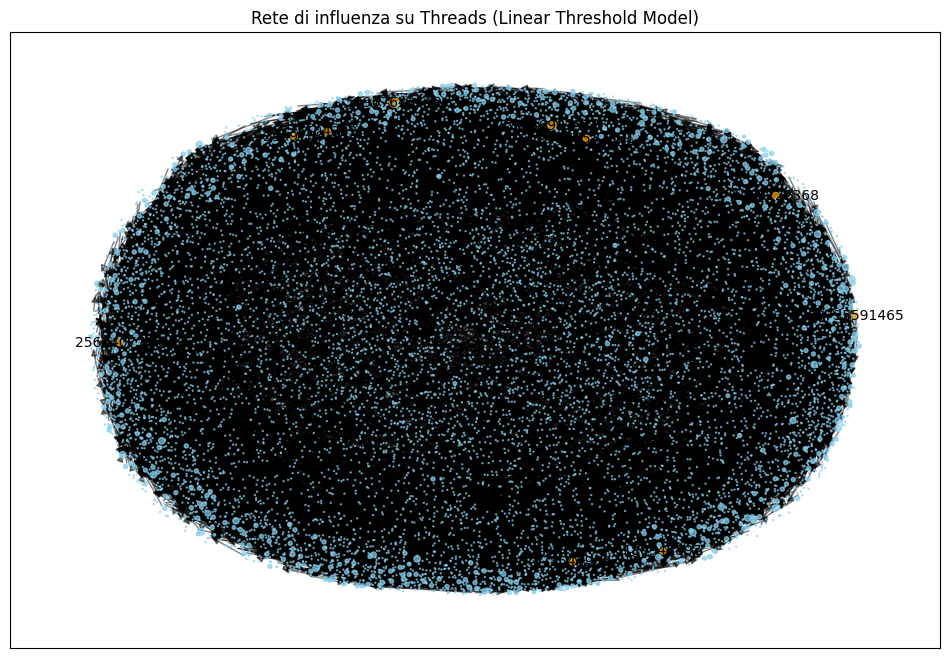

In [51]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)
node_colors = ["orange" if node in activated_nodes_lt else "skyblue" for node in G.nodes()]
node_sizes = [centralities.get("PageRank")[node] * 10000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, {node: node for node, _ in top_influencers}, font_size=10)
plt.title("Rete di influenza su Threads (Linear Threshold Model)")
plt.show()